In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
url = '/content/drive/MyDrive/4238/'

In [5]:
dataset_C = url + 'dataset_2_image.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [6]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()


,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [7]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [8]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base parameter**

In [9]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6


In [10]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:2400
Test dataloader:600


In [11]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [12]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [14]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.300342082977295. Accuracy: 9.908333333333333
Iteration: 1000. Loss: 2.302828311920166. Accuracy: 18.566666666666666
Iteration: 1500. Loss: 2.2867488861083984. Accuracy: 31.466666666666665
Iteration: 2000. Loss: 2.1350150108337402. Accuracy: 19.65
Epoch:  2
Iteration: 2500. Loss: 1.0355050563812256. Accuracy: 54.19166666666667
Iteration: 3000. Loss: 0.7427798509597778. Accuracy: 66.60833333333333
Iteration: 3500. Loss: 0.9775316119194031. Accuracy: 67.5
Iteration: 4000. Loss: 0.5209141969680786. Accuracy: 71.675
Iteration: 4500. Loss: 0.7858859300613403. Accuracy: 71.68333333333334
Epoch:  3
Iteration: 5000. Loss: 0.7016154527664185. Accuracy: 74.975
Iteration: 5500. Loss: 0.499281644821167. Accuracy: 75.825
Iteration: 6000. Loss: 0.4463684558868408. Accuracy: 75.00833333333334
Iteration: 6500. Loss: 0.3441336154937744. Accuracy: 79.94166666666666
Iteration: 7000. Loss: 0.30912521481513977. Accuracy: 76.7
Epoch:  4
Iteration: 7500. Loss: 0.2942730486392

[2.300342082977295, 2.302828311920166, 2.2867488861083984, 2.1350150108337402, 1.0355050563812256, 0.7427798509597778, 0.9775316119194031, 0.5209141969680786, 0.7858859300613403, 0.7016154527664185, 0.499281644821167, 0.4463684558868408, 0.3441336154937744, 0.30912521481513977, 0.2942730486392975, 0.3583846688270569, 0.2732554078102112, 0.4822923243045807, 0.463663250207901, 0.22997570037841797, 0.45948919653892517, 0.3679656386375427, 0.5151966214179993, 0.39157387614250183, 0.43707484006881714, 0.35952526330947876, 0.613085925579071, 0.5570089817047119]


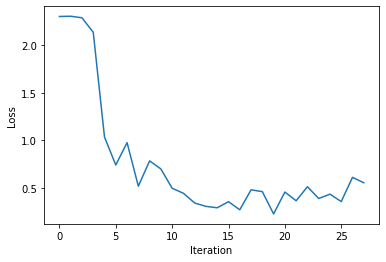

In [15]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **1st parameter**

In [ ]:
batch_size = 160
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

53


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:300
Test dataloader:75


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [16]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Iteration: 500. Loss: 2.3035635948181152. Accuracy: 9.708333333333334
Epoch:  3
Epoch:  4
Iteration: 1000. Loss: 2.30642032623291. Accuracy: 9.708333333333334
Epoch:  5
Iteration: 1500. Loss: 2.300788164138794. Accuracy: 9.708333333333334
Epoch:  6
Epoch:  7
Iteration: 2000. Loss: 2.3004486560821533. Accuracy: 9.708333333333334
Epoch:  8
Epoch:  9
Iteration: 2500. Loss: 2.3004403114318848. Accuracy: 9.708333333333334
Epoch:  10
Iteration: 3000. Loss: 2.301713466644287. Accuracy: 9.708333333333334
Epoch:  11
Epoch:  12
Iteration: 3500. Loss: 2.303467273712158. Accuracy: 9.708333333333334
Epoch:  13
Epoch:  14
Iteration: 4000. Loss: 2.30206036567688. Accuracy: 9.708333333333334
Epoch:  15
Iteration: 4500. Loss: 2.300164222717285. Accuracy: 9.708333333333334
Epoch:  16
Epoch:  17
Iteration: 5000. Loss: 2.3017754554748535. Accuracy: 9.708333333333334
Epoch:  18
Epoch:  19
Iteration: 5500. Loss: 2.2991418838500977. Accuracy: 9.708333333333334
Epoch:  20
Iteration: 6000. 

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SoftComputing/Models/model_base.pkl')

[2.299156904220581, 2.297672748565674, 2.2894980907440186, 2.2174315452575684, 2.168926477432251, 2.1636240482330322, 2.1168837547302246, 2.0823447704315186, 2.1153063774108887, 2.189105272293091, 2.5992228984832764, 1.992919921875, 2.0323586463928223, 1.8592212200164795, 1.9729278087615967, 1.6864557266235352, 1.698714256286621, 1.7902183532714844, 1.9283621311187744, 1.7759249210357666, 1.6246389150619507, 1.7828105688095093, 1.6225640773773193, 1.607317328453064, 1.3969322443008423, 1.2446510791778564, 1.210620641708374, 1.5196449756622314, 1.335086464881897, 1.249072790145874, 1.3305909633636475, 1.2058521509170532, 1.1778199672698975, 1.0261679887771606, 1.1026332378387451, 1.1505647897720337, 1.0218572616577148, 0.8724683523178101, 1.6969444751739502, 6.386862754821777, 1.366180181503296, 0.9178085327148438, 1.0142598152160645, 0.8064029812812805, 0.6427953243255615, 1.7719676494598389, 0.7417698502540588, 0.9788020253181458, 0.7263976335525513, 0.48985567688941956, 0.87709969282

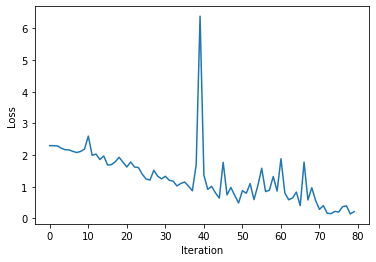

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()